## Setup (Colab)

If in colab, you will need to install these dependencies, download this data, and the model weights. If you are not in colab, you may have some of these already installed, or may need to install other dependencies (e.g. pytorch).

At the moment, every block in this section is commented out. Uncomment in order to run in colab and install/download.

### Install dependencies

In [4]:
!pip install biopython biotite
!pip install git+https://github.com/facebookresearch/esm.git
!apt-get install aria2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 13.9 MB/s 
     |████████████████████████████████| 31.8 MB 1.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for biotite: filename=biotite-0.34.1-cp37-cp37m-linux_x86_64.whl size=38757459 sha256=6bfa6156e600bf540d6cbb4d23092febe44fc87dcbb29d7bbb1a714e6c9013b9
  Stored in directory: /root/.cache/pip/wheels/41/ce/9d/53754c47fa26b09e989e110c2e429be1f1754d140289db0083
Successfully built biotite
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/esm.git to /tmp/pip-req-build-dg702pno
  Running command git clone -q https://github.com/facebookresearch/esm.git /tmp/pip-req-build-dg702pno
  Installing build dependencies ... done
  Getting requirements to buil

### Download Data

In [2]:
# # Download MSAs from esm example repo
!curl -O https://raw.githubusercontent.com/facebookresearch/esm/main/examples/data/1a3a_1_A.a3m
!curl -O https://raw.githubusercontent.com/facebookresearch/esm/main/examples/data/5ahw_1_A.a3m
!curl -O https://raw.githubusercontent.com/facebookresearch/esm/main/examples/data/1xcr_1_A.a3m

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  147k  100  147k    0     0  1761k      0 --:--:-- --:--:-- --:--:-- 1761k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  127k  100  127k    0     0  1103k      0 --:--:-- --:--:-- --:--:-- 1103k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  181k  100  181k    0     0  1870k      0 --:--:-- --:--:-- --:--:-- 1870k


### Download model weights
This download code is technically unnecessary. ESM will download weights automatically. However, it's *really* slow on colab. aria2c is much faster.

In [5]:
!mkdir -p /root/.cache/torch/hub/checkpoints
!aria2c --dir=/root/.cache/torch/hub/checkpoints --continue --split 8 --max-connection-per-server 8\
    https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50S.pt
!aria2c --dir=/root/.cache/torch/hub/checkpoints --continue --split 8 --max-connection-per-server 8\
    https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50S-contact-regression.pt
!aria2c --dir=/root/.cache/torch/hub/checkpoints --continue --split 8 --max-connection-per-server 8\
    https://dl.fbaipublicfiles.com/fair-esm/models/esm_msa1b_t12_100M_UR50S.pt
!aria2c --dir=/root/.cache/torch/hub/checkpoints --continue --split 8 --max-connection-per-server 8\
    https://dl.fbaipublicfiles.com/fair-esm/regression/esm_msa1b_t12_100M_UR50S-contact-regression.pt


08/26 06:17:18 [NOTICE] Downloading 1 item(s)

08/26 06:17:18 [ERROR] CUID#7 - Download aborted. URI=https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50S.pt
Exception: [AbstractCommand.cc:351] errorCode=22 URI=https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50S.pt
  -> [HttpSkipResponseCommand.cc:239] errorCode=22 The response status is not successful. status=403

08/26 06:17:18 [NOTICE] Download GID#62db8179e08dd349 not complete: 

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
62db81|ERR |       0B/s|https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50S.pt

Status Legend:
(ERR):error occurred.

aria2 will resume download if the transfer is restarted.
If there are any errors, then see the log file. See '-l' option in help/man page for details.

08/26 06:17:18 [NOTICE] Downloading 1 item(s)

08/26 06:17:19 [ERROR] CUID#7 - Download aborted. URI=https://dl.fbaip

## Imports

In [7]:
from typing import List, Tuple, Optional, Dict, NamedTuple, Union, Callable
import itertools
import os
import string
from pathlib import Path

import numpy as np
import torch
from scipy.spatial.distance import squareform, pdist, cdist
import matplotlib.pyplot as plt
import matplotlib as mpl
from Bio import SeqIO
import biotite.structure as bs
from biotite.structure.io.pdbx import PDBxFile, get_structure
from biotite.database import rcsb
from tqdm import tqdm
import pandas as pd

import esm

torch.set_grad_enabled(False)

## Define Functions

### Parsing alignments

In [8]:
# This is an efficient way to delete lowercase characters and insertion characters from a string
deletekeys = dict.fromkeys(string.ascii_lowercase)
deletekeys["."] = None
deletekeys["*"] = None
translation = str.maketrans(deletekeys)

def read_sequence(filename: str) -> Tuple[str, str]:
    """ Reads the first (reference) sequences from a fasta or MSA file."""
    record = next(SeqIO.parse(filename, "fasta"))
    return record.description, str(record.seq)

def remove_insertions(sequence: str) -> str:
    """ Removes any insertions into the sequence. Needed to load aligned sequences in an MSA. """
    return sequence.translate(translation)

def read_msa(filename: str) -> List[Tuple[str, str]]:
    """ Reads the sequences from an MSA file, automatically removes insertions."""
    return [(record.description, remove_insertions(str(record.seq))) for record in SeqIO.parse(filename, "fasta")]

### Converting structures to contacts

There are many ways to define a protein contact. Here we're using the definition of 8 angstroms between carbon beta atoms. Note that the position of the carbon beta is imputed from the position of the N, CA, and C atoms for each residue.

In [9]:
def extend(a, b, c, L, A, D):
    """
    input:  3 coords (a,b,c), (L)ength, (A)ngle, and (D)ihedral
    output: 4th coord
    """

    def normalize(x):
        return x / np.linalg.norm(x, ord=2, axis=-1, keepdims=True)

    bc = normalize(b - c)
    n = normalize(np.cross(b - a, bc))
    m = [bc, np.cross(n, bc), n]
    d = [L * np.cos(A), L * np.sin(A) * np.cos(D), -L * np.sin(A) * np.sin(D)]
    return c + sum([m * d for m, d in zip(m, d)])


def contacts_from_pdb(
    structure: bs.AtomArray,
    distance_threshold: float = 8.0,
    chain: Optional[str] = None,
) -> np.ndarray:
    mask = ~structure.hetero
    if chain is not None:
        mask &= structure.chain_id == chain

    N = structure.coord[mask & (structure.atom_name == "N")]
    CA = structure.coord[mask & (structure.atom_name == "CA")]
    C = structure.coord[mask & (structure.atom_name == "C")]

    Cbeta = extend(C, N, CA, 1.522, 1.927, -2.143)
    dist = squareform(pdist(Cbeta))
    
    contacts = dist < distance_threshold
    contacts = contacts.astype(np.int64)
    contacts[np.isnan(dist)] = -1
    return contacts

### Subsampling MSA

In [ ]:
# Select sequences from the MSA to maximize the hamming distance
# Alternatively, can use hhfilter 
def greedy_select(msa: List[Tuple[str, str]], num_seqs: int, mode: str = "max") -> List[Tuple[str, str]]:
    assert mode in ("max", "min")
    if len(msa) <= num_seqs:
        return msa
    
    array = np.array([list(seq) for _, seq in msa], dtype=np.bytes_).view(np.uint8)

    optfunc = np.argmax if mode == "max" else np.argmin
    all_indices = np.arange(len(msa))
    indices = [0]
    pairwise_distances = np.zeros((0, len(msa)))
    for _ in range(num_seqs - 1):
        dist = cdist(array[indices[-1:]], array, "hamming")
        pairwise_distances = np.concatenate([pairwise_distances, dist])
        shifted_distance = np.delete(pairwise_distances, indices, axis=1).mean(0)
        shifted_index = optfunc(shifted_distance)
        index = np.delete(all_indices, indices)[shifted_index]
        indices.append(index)
    indices = sorted(indices)
    return [msa[idx] for idx in indices]

### Compute contact precisions

In [10]:
def compute_precisions(
    predictions: torch.Tensor,
    targets: torch.Tensor,
    src_lengths: Optional[torch.Tensor] = None,
    minsep: int = 6,
    maxsep: Optional[int] = None,
    override_length: Optional[int] = None,  # for casp
):
    if isinstance(predictions, np.ndarray):
        predictions = torch.from_numpy(predictions)
    if isinstance(targets, np.ndarray):
        targets = torch.from_numpy(targets)
    if predictions.dim() == 2:
        predictions = predictions.unsqueeze(0)
    if targets.dim() == 2:
        targets = targets.unsqueeze(0)
    override_length = (targets[0, 0] >= 0).sum()

    # Check sizes
    if predictions.size() != targets.size():
        raise ValueError(
            f"Size mismatch. Received predictions of size {predictions.size()}, "
            f"targets of size {targets.size()}"
        )
    device = predictions.device

    batch_size, seqlen, _ = predictions.size()
    seqlen_range = torch.arange(seqlen, device=device)

    sep = seqlen_range.unsqueeze(0) - seqlen_range.unsqueeze(1)
    sep = sep.unsqueeze(0)
    valid_mask = sep >= minsep
    valid_mask = valid_mask & (targets >= 0)  # negative targets are invalid

    if maxsep is not None:
        valid_mask &= sep < maxsep

    if src_lengths is not None:
        valid = seqlen_range.unsqueeze(0) < src_lengths.unsqueeze(1)
        valid_mask &= valid.unsqueeze(1) & valid.unsqueeze(2)
    else:
        src_lengths = torch.full([batch_size], seqlen, device=device, dtype=torch.long)

    predictions = predictions.masked_fill(~valid_mask, float("-inf"))

    x_ind, y_ind = np.triu_indices(seqlen, minsep)
    predictions_upper = predictions[:, x_ind, y_ind]
    targets_upper = targets[:, x_ind, y_ind]

    topk = seqlen if override_length is None else max(seqlen, override_length)
    indices = predictions_upper.argsort(dim=-1, descending=True)[:, :topk]
    topk_targets = targets_upper[torch.arange(batch_size).unsqueeze(1), indices]
    if topk_targets.size(1) < topk:
        topk_targets = F.pad(topk_targets, [0, topk - topk_targets.size(1)])

    cumulative_dist = topk_targets.type_as(predictions).cumsum(-1)

    gather_lengths = src_lengths.unsqueeze(1)
    if override_length is not None:
        gather_lengths = override_length * torch.ones_like(
            gather_lengths, device=device
        )

    gather_indices = (
        torch.arange(0.1, 1.1, 0.1, device=device).unsqueeze(0) * gather_lengths
    ).type(torch.long) - 1

    binned_cumulative_dist = cumulative_dist.gather(1, gather_indices)
    binned_precisions = binned_cumulative_dist / (gather_indices + 1).type_as(
        binned_cumulative_dist
    )

    pl5 = binned_precisions[:, 1]
    pl2 = binned_precisions[:, 4]
    pl = binned_precisions[:, 9]
    auc = binned_precisions.mean(-1)

    return {"AUC": auc, "P@L": pl, "P@L2": pl2, "P@L5": pl5}


def evaluate_prediction(
    predictions: torch.Tensor,
    targets: torch.Tensor,
) -> Dict[str, float]:
    if isinstance(targets, np.ndarray):
        targets = torch.from_numpy(targets)
    contact_ranges = [
        ("local", 3, 6),
        ("short", 6, 12),
        ("medium", 12, 24),
        ("long", 24, None),
    ]
    metrics = {}
    targets = targets.to(predictions.device)
    for name, minsep, maxsep in contact_ranges:
        rangemetrics = compute_precisions(
            predictions,
            targets,
            minsep=minsep,
            maxsep=maxsep,
        )
        for key, val in rangemetrics.items():
            metrics[f"{name}_{key}"] = val.item()
    return metrics

### Plotting Results

In [11]:
"""Adapted from: https://github.com/rmrao/evo/blob/main/evo/visualize.py"""
def plot_contacts_and_predictions(
    predictions: Union[torch.Tensor, np.ndarray],
    contacts: Union[torch.Tensor, np.ndarray],
    ax: Optional[mpl.axes.Axes] = None,
    # artists: Optional[ContactAndPredictionArtists] = None,
    cmap: str = "Blues",
    ms: float = 1,
    title: Union[bool, str, Callable[[float], str]] = True,
    animated: bool = False,
) -> None:

    if isinstance(predictions, torch.Tensor):
        predictions = predictions.detach().cpu().numpy()
    if isinstance(contacts, torch.Tensor):
        contacts = contacts.detach().cpu().numpy()
    if ax is None:
        ax = plt.gca()

    seqlen = contacts.shape[0]
    relative_distance = np.add.outer(-np.arange(seqlen), np.arange(seqlen))
    bottom_mask = relative_distance < 0
    masked_image = np.ma.masked_where(bottom_mask, predictions)
    invalid_mask = np.abs(np.add.outer(np.arange(seqlen), -np.arange(seqlen))) < 6
    predictions = predictions.copy()
    predictions[invalid_mask] = float("-inf")

    topl_val = np.sort(predictions.reshape(-1))[-seqlen]
    pred_contacts = predictions >= topl_val
    true_positives = contacts & pred_contacts & ~bottom_mask
    false_positives = ~contacts & pred_contacts & ~bottom_mask
    other_contacts = contacts & ~pred_contacts & ~bottom_mask

    if isinstance(title, str):
        title_text: Optional[str] = title
    elif title:
        long_range_pl = compute_precisions(predictions, contacts, minsep=24)[
            "P@L"
        ].item()
        if callable(title):
            title_text = title(long_range_pl)
        else:
            title_text = f"Long Range P@L: {100 * long_range_pl:0.1f}"
    else:
        title_text = None

    img = ax.imshow(masked_image, cmap=cmap, animated=animated)
    oc = ax.plot(*np.where(other_contacts), "o", c="grey", ms=ms)[0]
    fn = ax.plot(*np.where(false_positives), "o", c="r", ms=ms)[0]
    tp = ax.plot(*np.where(true_positives), "o", c="b", ms=ms)[0]
    ti = ax.set_title(title_text) if title_text is not None else None
    # artists = ContactAndPredictionArtists(img, oc, fn, tp, ti)

    ax.axis("square")
    ax.set_xlim([0, seqlen])
    ax.set_ylim([0, seqlen])

## Predict and Visualize

### Read Data

In [16]:
# This is where the data is actually read in
PDB_IDS = ["1a3a", "5ahw", "1xcr"]

structures = {
    name.lower(): get_structure(PDBxFile.read(rcsb.fetch(name, "cif")))[0]
    for name in PDB_IDS
}

contacts = {
    name: contacts_from_pdb(structure, chain="A") 
    for name, structure in structures.items()
}

msas = {
    name: read_msa(f"{name.lower()}_1_A.a3m")
    for name in PDB_IDS
}

sequences = {
    name: msa[0] for name, msa in msas.items()
}
print(sequences)

{'1a3a': ('', 'LFKLGAENIFLGRKAATKEEAIRFAGEQLVKGGYVEPEYVQAMLDREKLTPTYLGESIAVPHGTVEAKDRVLKTGVVFCQYPEGVRFGEEEDDIARLVIGIAARNNEHIQVITSLTNALDDESVIERLAHTTSVDEVLELLAGRK'), '5ahw': ('', 'SAYQTVVVGTDGSDSSLRAVDRAGQIAAASNAKLIIATAYFPAPIYAILREANDRAKAAGATDIEERPVVGAPVDALVELADEVKADLLVVGNVGLSTIAGRLLGSVPANVARRSKTDVLIVHTS'), '1xcr': ('', 'CAEFSFHVPSLEELAGVMQKGLKDNFADVQVSVVDCPDLTKEPFTFPVKGICGKTRIAEVGGVPYLLPLVNQKKVYDLNKIAKEIKLPGAFILGAGAGPFQTLGFNSEFMPVIQTESEHKPPVNGSYFAHVNPADGGCLLEKYSEKCHDFQCALLANLFASEGQPGKVIEVKAKRRTGPLNFVTCMRETLEKHYGNKPIGMGGTFIIQKGKVKSHIMPAEFSSCPLNSDEEVNKWLHFYEMKAPLVCLPVFVSRDPGFDLRLEHTHFFSRHGEGGHYHYDTTPDIVEYLGYFLPAEFLYRIDQPKETHSIGRD')}


### ESM-2 Predictions

In [13]:
esm2, esm2_alphabet = esm.pretrained.esm2_t33_650M_UR50D()
esm2 = esm2.eval().cuda()
esm2_batch_converter = esm2_alphabet.get_batch_converter()

Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D-contact-regression.pt


In [14]:
esm2_predictions = {}
esm2_results = []
for name, inputs in sequences.items():
    print(name, inputs)
    esm2_batch_labels, esm2_batch_strs, esm2_batch_tokens = esm2_batch_converter([inputs])
    esm2_batch_tokens = esm2_batch_tokens.to(next(esm2.parameters()).device)
    esm2_predictions[name] = esm2.predict_contacts(esm2_batch_tokens)[0].cpu()
    metrics = {"id": name, "model": "ESM-2 (Unsupervised)"}
    metrics.update(evaluate_prediction(esm2_predictions[name], contacts[name]))
    esm2_results.append(metrics)
esm2_results = pd.DataFrame(esm2_results)
display(esm2_results)

1a3a ('', 'LFKLGAENIFLGRKAATKEEAIRFAGEQLVKGGYVEPEYVQAMLDREKLTPTYLGESIAVPHGTVEAKDRVLKTGVVFCQYPEGVRFGEEEDDIARLVIGIAARNNEHIQVITSLTNALDDESVIERLAHTTSVDEVLELLAGRK')
5ahw ('', 'SAYQTVVVGTDGSDSSLRAVDRAGQIAAASNAKLIIATAYFPAPIYAILREANDRAKAAGATDIEERPVVGAPVDALVELADEVKADLLVVGNVGLSTIAGRLLGSVPANVARRSKTDVLIVHTS')
1xcr ('', 'CAEFSFHVPSLEELAGVMQKGLKDNFADVQVSVVDCPDLTKEPFTFPVKGICGKTRIAEVGGVPYLLPLVNQKKVYDLNKIAKEIKLPGAFILGAGAGPFQTLGFNSEFMPVIQTESEHKPPVNGSYFAHVNPADGGCLLEKYSEKCHDFQCALLANLFASEGQPGKVIEVKAKRRTGPLNFVTCMRETLEKHYGNKPIGMGGTFIIQKGKVKSHIMPAEFSSCPLNSDEEVNKWLHFYEMKAPLVCLPVFVSRDPGFDLRLEHTHFFSRHGEGGHYHYDTTPDIVEYLGYFLPAEFLYRIDQPKETHSIGRD')


,id,model,local_AUC,local_P@L,local_P@L2,local_P@L5,short_AUC,short_P@L,short_P@L2,short_P@L5,medium_AUC,medium_P@L,medium_P@L2,medium_P@L5,long_AUC,long_P@L,long_P@L2,long_P@L5
0,1a3a,ESM-2 (Unsupervised),0.801181,0.662069,0.805556,0.896552,0.528245,0.296552,0.500000,0.827586,0.612222,0.344828,0.569444,0.931035,0.806507,0.689655,0.791667,0.931035
1,5ahw,ESM-2 (Unsupervised),0.819763,0.680000,0.838710,0.960000,0.543314,0.296000,0.500000,0.840000,0.569258,0.304000,0.548387,0.920000,0.937361,0.864000,0.951613,0.960000
2,1xcr,ESM-2 (Unsupervised),0.529522,0.351438,0.500000,0.693548,0.344734,0.204473,0.320513,0.516129,0.410161,0.265176,0.365385,0.596774,0.576668,0.408946,0.544872,0.758065


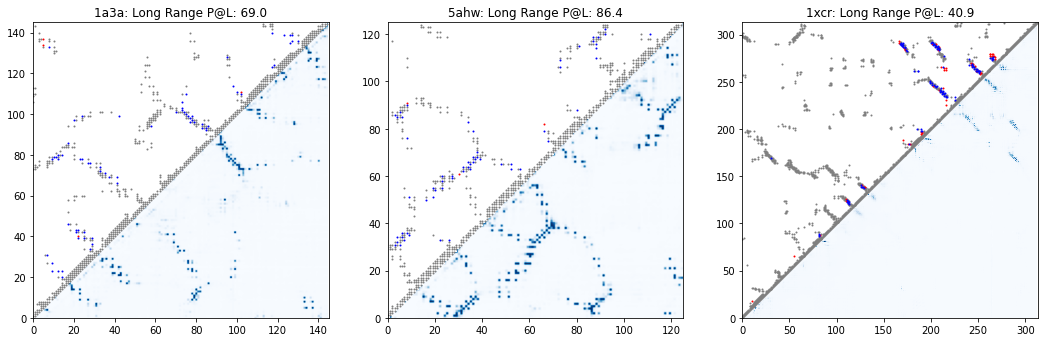

In [15]:
fig, axes = plt.subplots(figsize=(18, 6), ncols=3)
for ax, name in zip(axes, PDB_IDS):
    prediction = esm2_predictions[name]
    target = contacts[name]
    plot_contacts_and_predictions(
        prediction, target, ax=ax, title = lambda prec: f"{name}: Long Range P@L: {100 * prec:0.1f}"
    )
plt.show()

In [25]:
esm2_predictions = {}
esm2_results = []
name='1a3a'
inputs=('', 'LFKLGAENIFLGRKAATKEEAIRFAGEQLVKGGYVEPEYVQAMLDREKLTPTYLGESIAVPHGTVEAKDRVLKTGVVFCQYPEGVRFGEEEDDIARLVIGIAARNNEHIQVITSLTNALDDESVIERLAHTTSVDEVLELLAGRK')
print(name, inputs)
esm2_batch_labels, esm2_batch_strs, esm2_batch_tokens = esm2_batch_converter([inputs])
esm2_batch_tokens = esm2_batch_tokens.to(next(esm2.parameters()).device)
esm2_predictions[name] = esm2.predict_contacts(esm2_batch_tokens)[0].cpu()
metrics = {"id": name, "model": "ESM-2 (Unsupervised)"}
metrics.update(evaluate_prediction(esm2_predictions[name], contacts[name]))
esm2_results.append(metrics)
name0='1a3a'

name='1a3a_attack_5pos_0'
inputs=('', 'LFKLGAENLFLGRKAATKEEAIRFAGEQLVKGGYVEPEYVQAMLDREKLTPTYLGESIAVPHGTVEAKDRVLKTGVVFCQYPEGVRYGEEEDDIARLVIGIAARNNSHIQVITSLTNALDDESVIERLAHTTSVDQVLELFAGRK')
print(name, inputs)
esm2_batch_labels, esm2_batch_strs, esm2_batch_tokens = esm2_batch_converter([inputs])
esm2_batch_tokens = esm2_batch_tokens.to(next(esm2.parameters()).device)
esm2_predictions[name] = esm2.predict_contacts(esm2_batch_tokens)[0].cpu()
metrics = {"id": name, "model": "ESM-2 (Unsupervised)"}
metrics.update(evaluate_prediction(esm2_predictions[name], contacts[name0]))
esm2_results.append(metrics)

name='1a3a_attack_5pos_1'
inputs=('', 'LFKLGAENLFLGRKAATKEEAIRFAGEQLVKGGYVEPEYVQAMLDREKLTPTYLGESIAVPHGTVEAKDRVLKTGVVFCQYPEGLRFGEEEDDIARLVIGIAARNNEHVQVITSLTNALDDESVIERMAHTTSVDEVLELFAGRK')
print(name, inputs)
esm2_batch_labels, esm2_batch_strs, esm2_batch_tokens = esm2_batch_converter([inputs])
esm2_batch_tokens = esm2_batch_tokens.to(next(esm2.parameters()).device)
esm2_predictions[name] = esm2.predict_contacts(esm2_batch_tokens)[0].cpu()
metrics = {"id": name, "model": "ESM-2 (Unsupervised)"}
metrics.update(evaluate_prediction(esm2_predictions[name], contacts[name0]))
esm2_results.append(metrics)

name='1a3a_attack_10pos_0'
inputs=('','LFKFGAENIFLGRKAATKEELIRFAGEQLVKGGYVEPEYVQAILDREKLTPTYLPESIAVPNGTVEAKDRALKTSVVFCQYPEGVRFGEEEDDIARVVIGFAARNNSHIQVITSLTNALDDESVIERLAHTTSVDEVLELLAGRK')
print(name, inputs)
esm2_batch_labels, esm2_batch_strs, esm2_batch_tokens = esm2_batch_converter([inputs])
esm2_batch_tokens = esm2_batch_tokens.to(next(esm2.parameters()).device)
esm2_predictions[name] = esm2.predict_contacts(esm2_batch_tokens)[0].cpu()
metrics = {"id": name, "model": "ESM-2 (Unsupervised)"}
metrics.update(evaluate_prediction(esm2_predictions[name], contacts[name0]))
esm2_results.append(metrics)

name='1a3a_attack_10pos_1'
inputs=('','LFKLGAENIFLGRKAATREEAIRFAGEQAVKGGYVEPEYVQAMLDSEKLTPTYLGENIAVLHGTVEAKDRVLKTGVVFCQYPEGLRYGEEEDDIARLVIGISARNNEHIQVMTSLTNALDEESVIERLAHTTSVDEVLELLAGRK')
print(name, inputs)
esm2_batch_labels, esm2_batch_strs, esm2_batch_tokens = esm2_batch_converter([inputs])
esm2_batch_tokens = esm2_batch_tokens.to(next(esm2.parameters()).device)
esm2_predictions[name] = esm2.predict_contacts(esm2_batch_tokens)[0].cpu()
metrics = {"id": name, "model": "ESM-2 (Unsupervised)"}
metrics.update(evaluate_prediction(esm2_predictions[name], contacts[name0]))
esm2_results.append(metrics)

name='1a3a_attack_20pos_0'
inputs=('','KFKFGAENLFVGRKAATKEEAVRFAGEQAVKGGYAEPEYVQAMLDREKLTPTYLGENISVLHTTVAAKDRVLKTSVVFCQYPEGVRFGEEEDDIIRVVIGISARNNSHIQVITSLTNAIDDESVIERLAHSTSVDEVLELLAGRK')
print(name, inputs)
esm2_batch_labels, esm2_batch_strs, esm2_batch_tokens = esm2_batch_converter([inputs])
esm2_batch_tokens = esm2_batch_tokens.to(next(esm2.parameters()).device)
esm2_predictions[name] = esm2.predict_contacts(esm2_batch_tokens)[0].cpu()
metrics = {"id": name, "model": "ESM-2 (Unsupervised)"}
metrics.update(evaluate_prediction(esm2_predictions[name], contacts[name0]))
esm2_results.append(metrics)

name='1a3a_attack_20pos_1'
inputs=('','KFKFGAENIFVGRKAATREQAIRFAGEQAVKGKYVEPEVVQAILDRDKLTPPYLPENIAVLHGTVEAKDRVLKTGVVFCQYPEAVRFGEEEDDIARLVIGIAARNNEYIQVITSVTNAIDDESVIERLAHTTSVDQVLELFAGRK')
print(name, inputs)
esm2_batch_labels, esm2_batch_strs, esm2_batch_tokens = esm2_batch_converter([inputs])
esm2_batch_tokens = esm2_batch_tokens.to(next(esm2.parameters()).device)
esm2_predictions[name] = esm2.predict_contacts(esm2_batch_tokens)[0].cpu()
metrics = {"id": name, "model": "ESM-2 (Unsupervised)"}
metrics.update(evaluate_prediction(esm2_predictions[name], contacts[name0]))
esm2_results.append(metrics)

esm2_results = pd.DataFrame(esm2_results)
display(esm2_results)

1a3a ('', 'LFKLGAENIFLGRKAATKEEAIRFAGEQLVKGGYVEPEYVQAMLDREKLTPTYLGESIAVPHGTVEAKDRVLKTGVVFCQYPEGVRFGEEEDDIARLVIGIAARNNEHIQVITSLTNALDDESVIERLAHTTSVDEVLELLAGRK')
1a3a_attack_5pos_0 ('', 'LFKLGAENLFLGRKAATKEEAIRFAGEQLVKGGYVEPEYVQAMLDREKLTPTYLGESIAVPHGTVEAKDRVLKTGVVFCQYPEGVRYGEEEDDIARLVIGIAARNNSHIQVITSLTNALDDESVIERLAHTTSVDQVLELFAGRK')
1a3a_attack_5pos_1 ('', 'LFKLGAENLFLGRKAATKEEAIRFAGEQLVKGGYVEPEYVQAMLDREKLTPTYLGESIAVPHGTVEAKDRVLKTGVVFCQYPEGLRFGEEEDDIARLVIGIAARNNEHVQVITSLTNALDDESVIERMAHTTSVDEVLELFAGRK')
1a3a_attack_10pos_0 ('', 'LFKFGAENIFLGRKAATKEELIRFAGEQLVKGGYVEPEYVQAILDREKLTPTYLPESIAVPNGTVEAKDRALKTSVVFCQYPEGVRFGEEEDDIARVVIGFAARNNSHIQVITSLTNALDDESVIERLAHTTSVDEVLELLAGRK')
1a3a_attack_10pos_1 ('', 'LFKLGAENIFLGRKAATREEAIRFAGEQAVKGGYVEPEYVQAMLDSEKLTPTYLGENIAVLHGTVEAKDRVLKTGVVFCQYPEGLRYGEEEDDIARLVIGISARNNEHIQVMTSLTNALDEESVIERLAHTTSVDEVLELLAGRK')
1a3a_attack_20pos_0 ('', 'KFKFGAENLFVGRKAATKEEAVRFAGEQAVKGGYAEPEYVQAMLDREKLTPTYLGENISVLHTTVAAKDRVLKTSVVFCQYPEGVRFGEEEDDIIRVVIGISARNNSHIQVITSLTNAIDD

,id,model,local_AUC,local_P@L,local_P@L2,local_P@L5,short_AUC,short_P@L,short_P@L2,short_P@L5,medium_AUC,medium_P@L,medium_P@L2,medium_P@L5,long_AUC,long_P@L,long_P@L2,long_P@L5
0,1a3a,ESM-2 (Unsupervised),0.801181,0.662069,0.805556,0.896552,0.528245,0.296552,0.500000,0.827586,0.612222,0.344828,0.569444,0.931035,0.806507,0.689655,0.791667,0.931035
1,1a3a_attack_5pos_0,ESM-2 (Unsupervised),0.795102,0.662069,0.791667,0.896552,0.529581,0.296552,0.500000,0.827586,0.608438,0.344828,0.583333,0.896552,0.807493,0.696552,0.791667,0.931035
2,1a3a_attack_5pos_1,ESM-2 (Unsupervised),0.795930,0.668966,0.819444,0.862069,0.531481,0.296552,0.486111,0.827586,0.609172,0.344828,0.583333,0.896552,0.800306,0.703448,0.805556,0.931035
3,1a3a_attack_10pos_0,ESM-2 (Unsupervised),0.788767,0.648276,0.791667,0.896552,0.524938,0.296552,0.486111,0.827586,0.609080,0.344828,0.583333,0.896552,0.801477,0.689655,0.819444,0.896552
4,1a3a_attack_10pos_1,ESM-2 (Unsupervised),0.788489,0.655172,0.805556,0.827586,0.540382,0.303448,0.513889,0.862069,0.617861,0.344828,0.611111,0.862069,0.809837,0.717241,0.805556,0.931035
5,1a3a_attack_20pos_0,ESM-2 (Unsupervised),0.767447,0.641379,0.805556,0.758621,0.535181,0.296552,0.500000,0.862069,0.622127,0.351724,0.611111,0.931035,0.805455,0.703448,0.805556,0.931035
6,1a3a_attack_20pos_1,ESM-2 (Unsupervised),0.777997,0.641379,0.777778,0.862069,0.518950,0.289655,0.458333,0.827586,0.614085,0.351724,0.611111,0.896552,0.790449,0.689655,0.763889,0.896552


In [26]:
esm2_predictions = {}
esm2_results = []
name='1a3a'
inputs=('', 'LFKLGAENIFLGRKAATKEEAIRFAGEQLVKGGYVEPEYVQAMLDREKLTPTYLGESIAVPHGTVEAKDRVLKTGVVFCQYPEGVRFGEEEDDIARLVIGIAARNNEHIQVITSLTNALDDESVIERLAHTTSVDEVLELLAGRK')
print(name, inputs)
esm2_batch_labels, esm2_batch_strs, esm2_batch_tokens = esm2_batch_converter([inputs])
esm2_batch_tokens = esm2_batch_tokens.to(next(esm2.parameters()).device)
esm2_predictions[name] = esm2.predict_contacts(esm2_batch_tokens)[0].cpu()
metrics = {"id": name, "model": "ESM-2 (Unsupervised)"}
metrics.update(evaluate_prediction(esm2_predictions[name], contacts[name]))
esm2_results.append(metrics)

name0='1a3a'
name='1a3a_attack_20pos_0'
inputs=('','KFKFGAENLFVGRKAATKEEAVRFAGEQAVKGGYAEPEYVQAMLDREKLTPTYLGENISVLHTTVAAKDRVLKTSVVFCQYPEGVRFGEEEDDIIRVVIGISARNNSHIQVITSLTNAIDDESVIERLAHSTSVDEVLELLAGRK')
print(name, inputs)
esm2_batch_labels, esm2_batch_strs, esm2_batch_tokens = esm2_batch_converter([inputs])
esm2_batch_tokens = esm2_batch_tokens.to(next(esm2.parameters()).device)
esm2_predictions[name] = esm2.predict_contacts(esm2_batch_tokens)[0].cpu()
metrics = {"id": name, "model": "ESM-2 (Unsupervised)"}
metrics.update(evaluate_prediction(esm2_predictions[name], contacts[name0]))
esm2_results.append(metrics)

name='1a3a_attack_20pos_1'
inputs=('','KFKFGAENIFVGRKAATREQAIRFAGEQAVKGKYVEPEVVQAILDRDKLTPPYLPENIAVLHGTVEAKDRVLKTGVVFCQYPEAVRFGEEEDDIARLVIGIAARNNEYIQVITSVTNAIDDESVIERLAHTTSVDQVLELFAGRK')
print(name, inputs)
esm2_batch_labels, esm2_batch_strs, esm2_batch_tokens = esm2_batch_converter([inputs])
esm2_batch_tokens = esm2_batch_tokens.to(next(esm2.parameters()).device)
esm2_predictions[name] = esm2.predict_contacts(esm2_batch_tokens)[0].cpu()
metrics = {"id": name, "model": "ESM-2 (Unsupervised)"}
metrics.update(evaluate_prediction(esm2_predictions[name], contacts[name0]))
esm2_results.append(metrics)

name='1a3a_attack_20pos_2'
inputs=('','LFKFGAENIFLGRKAATREELVRFAGEQLVKGGYVEPEVVQAMLDSDKLTPTYLGESIAVLNGTVEAKDRALKTGVVFCQYPEGLRFNEEEDDIIRLVIGIAARNNSHIQVMTSLTNAIDEESVIERMAHTTSVDEVLELFAGRY')
print(name, inputs)
esm2_batch_labels, esm2_batch_strs, esm2_batch_tokens = esm2_batch_converter([inputs])
esm2_batch_tokens = esm2_batch_tokens.to(next(esm2.parameters()).device)
esm2_predictions[name] = esm2.predict_contacts(esm2_batch_tokens)[0].cpu()
metrics = {"id": name, "model": "ESM-2 (Unsupervised)"}
metrics.update(evaluate_prediction(esm2_predictions[name], contacts[name0]))
esm2_results.append(metrics)

name='1a3a_attack_20pos_3'
inputs=('','KFKLGAENLFLGRKAATREEAIRFAGEQAVKGKYVEPEVVQAMLDRDKLTPTYLGESIAVPNTTVEAKDRVLKTSVVFCQYPEAVRYGEEEDDIIRLVIGISARNNSHVQVITSVTNAIDDESVIERLAHSTSVDEVLELFAGRK')
print(name, inputs)
esm2_batch_labels, esm2_batch_strs, esm2_batch_tokens = esm2_batch_converter([inputs])
esm2_batch_tokens = esm2_batch_tokens.to(next(esm2.parameters()).device)
esm2_predictions[name] = esm2.predict_contacts(esm2_batch_tokens)[0].cpu()
metrics = {"id": name, "model": "ESM-2 (Unsupervised)"}
metrics.update(evaluate_prediction(esm2_predictions[name], contacts[name0]))
esm2_results.append(metrics)

name='1a3a_attack_20pos_4'
inputs=('','KFKFGAENLFLGRKAATKEELIRFAGEQLVKGKYAEPEYVQAMLDREKLTPTYLGESISVLNTTVEAKDRVLKTGVVFCQYPEGVRFNEEEDDIIRVVIGISARNNEHVQVITSVTNAIDDESVIERLAHTTSVDEVLELFAGRY')
print(name, inputs)
esm2_batch_labels, esm2_batch_strs, esm2_batch_tokens = esm2_batch_converter([inputs])
esm2_batch_tokens = esm2_batch_tokens.to(next(esm2.parameters()).device)
esm2_predictions[name] = esm2.predict_contacts(esm2_batch_tokens)[0].cpu()
metrics = {"id": name, "model": "ESM-2 (Unsupervised)"}
metrics.update(evaluate_prediction(esm2_predictions[name], contacts[name0]))
esm2_results.append(metrics)

name='1a3a_attack_20pos_5'
inputs=('','KFKFGAENIFLGRKAATREEAIRFAGEQLVKGGYVEPEVVQAMLDSEKLTPPYLGESISVLHTTVEAKDRVLKTGVVFCQYPEAVRFNEEEDDIIRVVIGIAARNNSHVQVMTSLTNAIDDESVIERMAHSTSVDEVLELLAGRK')
print(name, inputs)
esm2_batch_labels, esm2_batch_strs, esm2_batch_tokens = esm2_batch_converter([inputs])
esm2_batch_tokens = esm2_batch_tokens.to(next(esm2.parameters()).device)
esm2_predictions[name] = esm2.predict_contacts(esm2_batch_tokens)[0].cpu()
metrics = {"id": name, "model": "ESM-2 (Unsupervised)"}
metrics.update(evaluate_prediction(esm2_predictions[name], contacts[name0]))
esm2_results.append(metrics)

esm2_results = pd.DataFrame(esm2_results)
display(esm2_results)

1a3a ('', 'LFKLGAENIFLGRKAATKEEAIRFAGEQLVKGGYVEPEYVQAMLDREKLTPTYLGESIAVPHGTVEAKDRVLKTGVVFCQYPEGVRFGEEEDDIARLVIGIAARNNEHIQVITSLTNALDDESVIERLAHTTSVDEVLELLAGRK')
1a3a_attack_20pos_0 ('', 'KFKFGAENLFVGRKAATKEEAVRFAGEQAVKGGYAEPEYVQAMLDREKLTPTYLGENISVLHTTVAAKDRVLKTSVVFCQYPEGVRFGEEEDDIIRVVIGISARNNSHIQVITSLTNAIDDESVIERLAHSTSVDEVLELLAGRK')
1a3a_attack_20pos_1 ('', 'KFKFGAENIFVGRKAATREQAIRFAGEQAVKGKYVEPEVVQAILDRDKLTPPYLPENIAVLHGTVEAKDRVLKTGVVFCQYPEAVRFGEEEDDIARLVIGIAARNNEYIQVITSVTNAIDDESVIERLAHTTSVDQVLELFAGRK')
1a3a_attack_20pos_2 ('', 'LFKFGAENIFLGRKAATREELVRFAGEQLVKGGYVEPEVVQAMLDSDKLTPTYLGESIAVLNGTVEAKDRALKTGVVFCQYPEGLRFNEEEDDIIRLVIGIAARNNSHIQVMTSLTNAIDEESVIERMAHTTSVDEVLELFAGRY')
1a3a_attack_20pos_3 ('', 'KFKLGAENLFLGRKAATREEAIRFAGEQAVKGKYVEPEVVQAMLDRDKLTPTYLGESIAVPNTTVEAKDRVLKTSVVFCQYPEAVRYGEEEDDIIRLVIGISARNNSHVQVITSVTNAIDDESVIERLAHSTSVDEVLELFAGRK')
1a3a_attack_20pos_4 ('', 'KFKFGAENLFLGRKAATKEELIRFAGEQLVKGKYAEPEYVQAMLDREKLTPTYLGESISVLNTTVEAKDRVLKTGVVFCQYPEGVRFNEEEDDIIRVVIGISARNNEHVQVITSVTNAI

,id,model,local_AUC,local_P@L,local_P@L2,local_P@L5,short_AUC,short_P@L,short_P@L2,short_P@L5,medium_AUC,medium_P@L,medium_P@L2,medium_P@L5,long_AUC,long_P@L,long_P@L2,long_P@L5
0,1a3a,ESM-2 (Unsupervised),0.801181,0.662069,0.805556,0.896552,0.528245,0.296552,0.500000,0.827586,0.612222,0.344828,0.569444,0.931035,0.806507,0.689655,0.791667,0.931035
1,1a3a_attack_20pos_0,ESM-2 (Unsupervised),0.767447,0.641379,0.805556,0.758621,0.535181,0.296552,0.500000,0.862069,0.622127,0.351724,0.611111,0.931035,0.805455,0.703448,0.805556,0.931035
2,1a3a_attack_20pos_1,ESM-2 (Unsupervised),0.777997,0.641379,0.777778,0.862069,0.518950,0.289655,0.458333,0.827586,0.614085,0.351724,0.611111,0.896552,0.790449,0.689655,0.763889,0.896552
3,1a3a_attack_20pos_2,ESM-2 (Unsupervised),0.782152,0.668966,0.777778,0.862069,0.530175,0.296552,0.513889,0.827586,0.607346,0.351724,0.583333,0.862069,0.806451,0.710345,0.819444,0.931035
4,1a3a_attack_20pos_3,ESM-2 (Unsupervised),0.778440,0.655172,0.791667,0.827586,0.511758,0.296552,0.458333,0.827586,0.613276,0.344828,0.597222,0.896552,0.795481,0.682759,0.791667,0.896552
5,1a3a_attack_20pos_4,ESM-2 (Unsupervised),0.778510,0.648276,0.777778,0.827586,0.527199,0.296552,0.500000,0.793103,0.611653,0.344828,0.597222,0.896552,0.792274,0.682759,0.833333,0.931035
6,1a3a_attack_20pos_5,ESM-2 (Unsupervised),0.772743,0.655172,0.791667,0.827586,0.526517,0.296552,0.500000,0.862069,0.618188,0.351724,0.625000,0.896552,0.797477,0.696552,0.805556,0.896552


KeyError: ignored

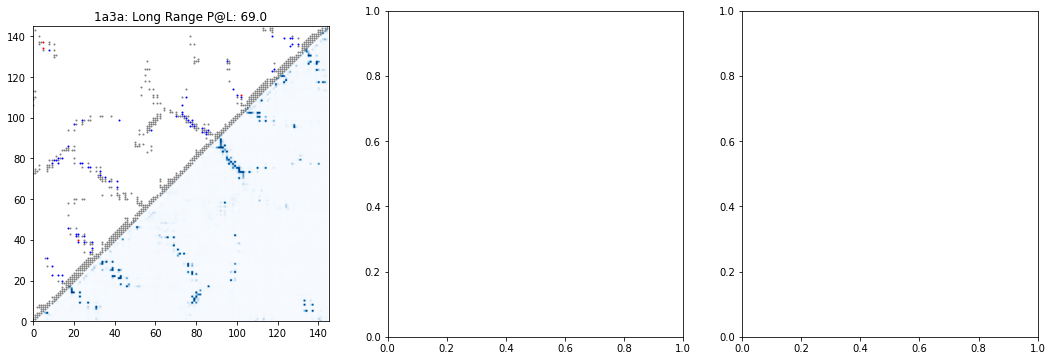

In [24]:
fig, axes = plt.subplots(figsize=(18, 6), ncols=3)
for ax, name in zip(axes, PDB_IDS):
    prediction = esm2_predictions[name]
    target = contacts[name]
    plot_contacts_and_predictions(
        prediction, target, ax=ax, title = lambda prec: f"{name}: Long Range P@L: {100 * prec:0.1f}"
    )
plt.show()

### MSA Transformer Predictions

In [ ]:
msa_transformer, msa_transformer_alphabet = esm.pretrained.esm_msa1b_t12_100M_UR50S()
msa_transformer = msa_transformer.eval().cuda()
msa_transformer_batch_converter = msa_transformer_alphabet.get_batch_converter()

In [ ]:
msa_transformer_predictions = {}
msa_transformer_results = []
for name, inputs in msas.items():
    inputs = greedy_select(inputs, num_seqs=128) # can change this to pass more/fewer sequences
    msa_transformer_batch_labels, msa_transformer_batch_strs, msa_transformer_batch_tokens = msa_transformer_batch_converter([inputs])
    msa_transformer_batch_tokens = msa_transformer_batch_tokens.to(next(msa_transformer.parameters()).device)
    msa_transformer_predictions[name] = msa_transformer.predict_contacts(msa_transformer_batch_tokens)[0].cpu()
    metrics = {"id": name, "model": "MSA Transformer (Unsupervised)"}
    metrics.update(evaluate_prediction(msa_transformer_predictions[name], contacts[name]))
    msa_transformer_results.append(metrics)
msa_transformer_results = pd.DataFrame(msa_transformer_results)
display(msa_transformer_results)

,id,model,local_AUC,local_P@L,local_P@L2,local_P@L5,short_AUC,short_P@L,short_P@L2,short_P@L5,medium_AUC,medium_P@L,medium_P@L2,medium_P@L5,long_AUC,long_P@L,long_P@L2,long_P@L5
0,1a3a,MSA Transformer (Unsupervised),0.853126,0.765517,0.875000,0.827586,0.575057,0.317241,0.569444,0.862069,0.601065,0.337931,0.597222,0.827586,0.837919,0.724138,0.861111,0.896552
1,5ahw,MSA Transformer (Unsupervised),0.850377,0.736000,0.854839,0.920000,0.547282,0.288000,0.548387,0.880000,0.581426,0.320000,0.548387,0.880000,0.967116,0.896000,0.967742,1.000000
2,1xcr,MSA Transformer (Unsupervised),0.675652,0.469649,0.679487,0.870968,0.470373,0.249201,0.442308,0.709677,0.508027,0.316294,0.487179,0.677419,0.878467,0.769968,0.891026,0.967742


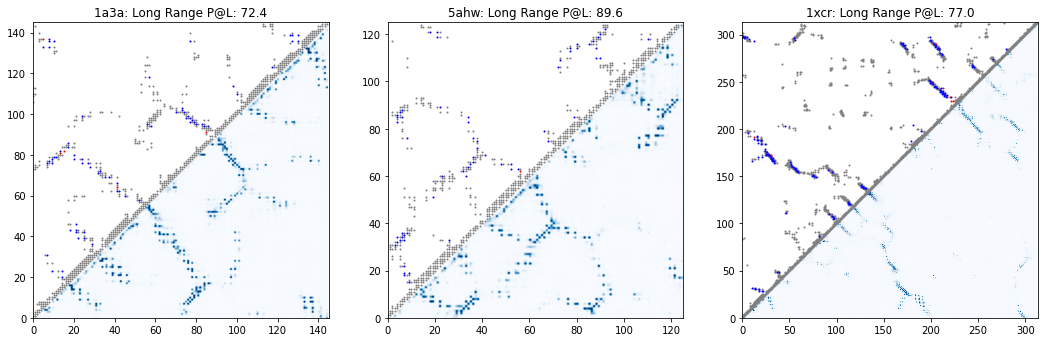

In [ ]:
fig, axes = plt.subplots(figsize=(18, 6), ncols=3)
for ax, name in zip(axes, PDB_IDS):
    prediction = msa_transformer_predictions[name]
    target = contacts[name]
    plot_contacts_and_predictions(
        prediction, target, ax=ax, title = lambda prec: f"{name}: Long Range P@L: {100 * prec:0.1f}"
    )
plt.show()